In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Loading the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merging customer and transaction data
customer_transactions = transactions.merge(customers, on='CustomerID')

# Creating customer profiles
customer_profiles = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'ProductID': 'nunique'
}).reset_index()

# Renaming of columns for clarity
customer_profiles.columns = ['CustomerID', 'TotalSpent', 'TransactionCount', 'UniqueProducts']

# Merging with customer demographics to include region information
customer_profiles = customer_profiles.merge(customers[['CustomerID', 'Region']], on='CustomerID')

In [34]:
# Preparing features for clustering
features = pd.get_dummies(customer_profiles[['Region']], drop_first=True)
features = pd.concat([customer_profiles[['TotalSpent', 'TransactionCount', 'UniqueProducts']], features], axis=1)

# Scaling of features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [35]:
# Applying PCA to reduce dimensionality
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_features = pca.fit_transform(scaled_features)

# Display the explained variance ratio
print(f"Explained variance by PCA components: {pca.explained_variance_ratio_}")

Explained variance by PCA components: [0.45386035 0.23035549]


In [38]:
# Experiment with different numbers of clusters
best_db_index = float('inf')
best_n_clusters = 0
best_labels = None

for n_clusters in range(3, 10):  # Test from 2 to 10 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pca_features)

    # Calculating the Davies-Bouldin Index
    db_index = davies_bouldin_score(pca_features, labels)

    if db_index < best_db_index:
        best_db_index = db_index
        best_n_clusters = n_clusters
        best_labels = labels

print(f"Best Number of Clusters: {best_n_clusters}")
print(f"Best Davies-Bouldin Index: {best_db_index:.4f}")

Best Number of Clusters: 8
Best Davies-Bouldin Index: 0.6316


In [32]:
# Calculate the silhouette score for the best clustering
silhouette_avg = silhouette_score(pca_features, best_labels)
print(f"Silhouette Score for Best Clustering: {silhouette_avg:.4f}")

Silhouette Score for Best Clustering: 0.4568


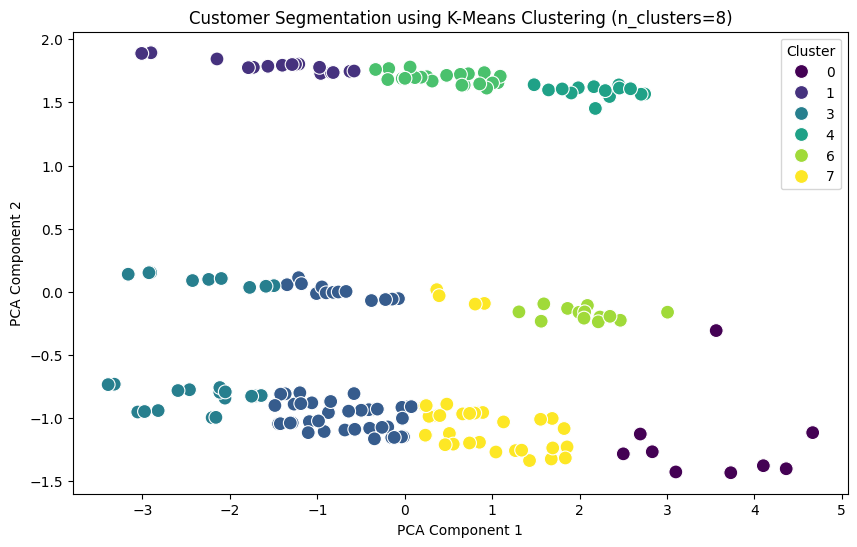

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=best_labels, palette='viridis', s=100)
plt.title(f'Customer Segmentation using K-Means Clustering (n_clusters={best_n_clusters})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()